------------
<font size=5 color=darkolivegreen>OPTIMIZATION MODEL

---------------------

In [1]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pulp

from scipy.stats import pearsonr, chi2_contingency

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/content/supply_chain_data.csv')
df.head()

,Product type,SKU,Price,Availability,Number of products sold,Revenue generated,Customer demographics,Stock levels,Lead times,Order quantities,...,Location,Lead time,Production volumes,Manufacturing lead time,Manufacturing costs,Inspection results,Defect rates,Transportation modes,Routes,Costs
0,haircare,SKU0,69.808006,55,802,8661.996792,Non-binary,58,7,96,...,Mumbai,29,215,29,46.279879,Pending,0.226410,Road,Route B,187.752075
1,skincare,SKU1,14.843523,95,736,7460.900065,Female,53,30,37,...,Mumbai,23,517,30,33.616769,Pending,4.854068,Road,Route B,503.065579
2,haircare,SKU2,11.319683,34,8,9577.749626,Unknown,1,10,88,...,Mumbai,12,971,27,30.688019,Pending,4.580593,Air,Route C,141.920282
3,skincare,SKU3,61.163343,68,83,7766.836426,Non-binary,23,13,59,...,Kolkata,24,937,18,35.624741,Fail,4.746649,Rail,Route A,254.776159
4,skincare,SKU4,4.805496,26,871,2686.505152,Non-binary,5,3,56,...,Delhi,5,414,3,92.065161,Fail,3.145580,Air,Route A,923.440632


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 24 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Product type             100 non-null    object 
 1   SKU                      100 non-null    object 
 2   Price                    100 non-null    float64
 3   Availability             100 non-null    int64  
 4   Number of products sold  100 non-null    int64  
 5   Revenue generated        100 non-null    float64
 6   Customer demographics    100 non-null    object 
 7   Stock levels             100 non-null    int64  
 8   Lead times               100 non-null    int64  
 9   Order quantities         100 non-null    int64  
 10  Shipping times           100 non-null    int64  
 11  Shipping carriers        100 non-null    object 
 12  Shipping costs           100 non-null    float64
 13  Supplier name            100 non-null    object 
 14  Location                 10

# Data Exploration and Validation

In [4]:
# Check for missing values and data integrity
missing_values = df.isnull().sum()
if missing_values.sum() > 0:
    print("Warning: Missing values detected:")
    print(missing_values[missing_values > 0])
else:
    print("No missing values in the dataset.")


No missing values in the dataset.


In [5]:
# Summary statistics for key columns used in optimization
key_columns = ['Price', 'Number of products sold', 'Stock levels', 'Manufacturing lead time', 'Manufacturing costs', 'Shipping costs']
print("\nSummary statistics for key columns:")
print(df[key_columns].describe().T)


Summary statistics for key columns:
                         count        mean         std       min         25%  \
Price                    100.0   49.462461   31.168193  1.699976   19.597823   
Number of products sold  100.0  460.990000  303.780074  8.000000  184.250000   
Stock levels             100.0   47.770000   31.369372  0.000000   16.750000   
Manufacturing lead time  100.0   14.770000    8.912430  1.000000    7.000000   
Manufacturing costs      100.0   47.266693   28.982841  1.085069   22.983299   
Shipping costs           100.0    5.548149    2.651376  1.013487    3.540248   

                                50%         75%         max  
Price                     51.239831   77.198228   99.171329  
Number of products sold  392.500000  704.250000  996.000000  
Stock levels              47.500000   73.000000  100.000000  
Manufacturing lead time   14.000000   23.000000   30.000000  
Manufacturing costs       45.905622   68.621026   99.466109  
Shipping costs             5.3

In [6]:
# Feasibility checks for constraints
total_demand = df['Number of products sold'].sum()
total_stock = df['Stock levels'].sum()
total_lead_time_capacity = 10000  # Assumed total available manufacturing time (e.g., in hours or days; adjust based on business context)
total_lead_time_required_min = (df['Number of products sold'] * df['Manufacturing lead time']).sum()  # Minimum time if producing exactly demand
total_lead_time_required_max = (df['Stock levels'] * df['Manufacturing lead time']).sum()  # Maximum possible time
print(f"\nFeasibility Overview:")
print(f"- Total Demand: {total_demand} units")
print(f"- Total Stock Capacity: {total_stock} units")
print(f"- Total Lead Time Capacity: {total_lead_time_capacity} units")
print(f"- Minimum Lead Time Required (at demand): {total_lead_time_required_min} units")
print(f"- Maximum Lead Time Required (at stock limit): {total_lead_time_required_max} units")
if total_demand > total_stock:
    print("Warning: Total demand exceeds total stock levels. Model may be infeasible.")
if total_lead_time_required_min > total_lead_time_capacity:
    print("Warning: Minimum lead time required exceeds capacity. Consider increasing capacity or relaxing constraints.")



Feasibility Overview:
- Total Demand: 46099 units
- Total Stock Capacity: 4777 units
- Total Lead Time Capacity: 10000 units
- Minimum Lead Time Required (at demand): 667765 units
- Maximum Lead Time Required (at stock limit): 69156 units


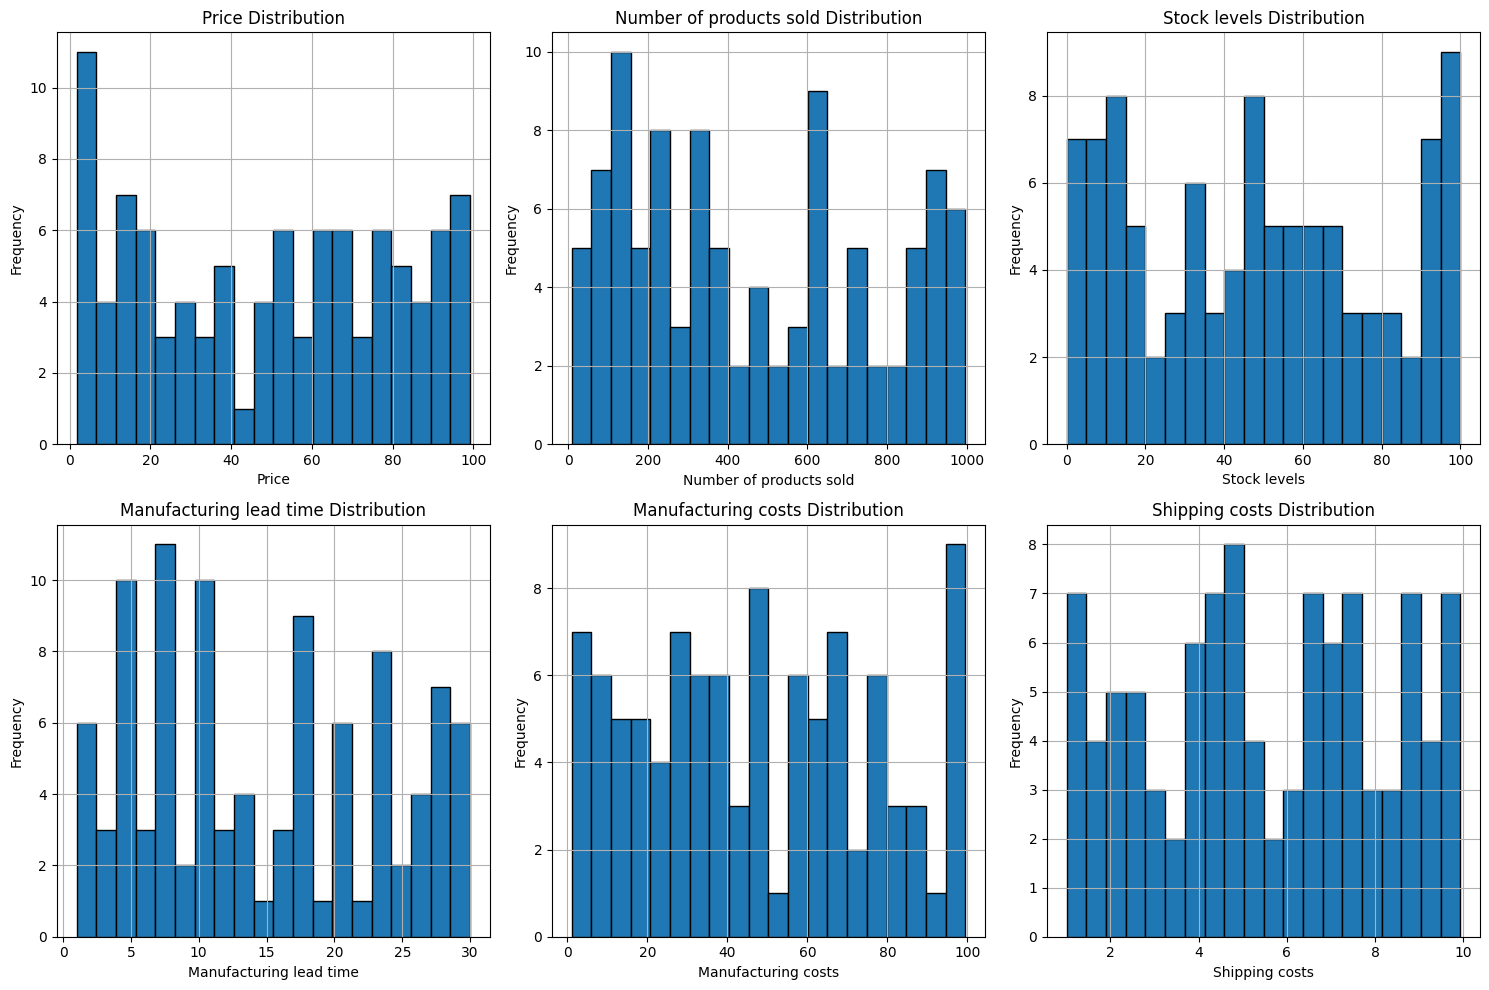

In [7]:
# Visualizations: Histograms for key distributions
fig, axes = plt.subplots(2, 3, figsize=(15, 10))
for i, col in enumerate(key_columns):
    ax = axes[i // 3, i % 3]
    df[col].hist(ax=ax, bins=20, edgecolor='black')
    ax.set_title(f'{col} Distribution')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
plt.tight_layout()
plt.show()

In [8]:
# Profit margin per product (for insight)
df['Profit_Margin'] = df['Price'] - df['Manufacturing costs'] - df['Shipping costs']
print(f"\nAverage Profit Margin: ${df['Profit_Margin'].mean():.2f} (Range: ${df['Profit_Margin'].min():.2f} to ${df['Profit_Margin'].max():.2f})")



Average Profit Margin: $-3.35 (Range: $-97.21 to $91.34)


# Optimization Model Formulation

In [10]:
# Define the LP problem: Maximize profit
import pulp
profit_maximization_problem = pulp.LpProblem("Supply_Chain_Profit_Maximization", pulp.LpMaximize)
# Decision variables: Production volume for each product (integer, >= 0)
product_indices = df.index.tolist()
production_volume_vars = pulp.LpVariable.dicts(
    "Production_Volume",
    product_indices,
    lowBound=0,
    cat='Integer'
)

# Objective function: Maximize total profit

In [11]:
# Profit = Sum over products: (Price - Manufacturing Cost - Shipping Cost) * Production Volume
profit_maximization_problem += pulp.lpSum([
    (df.loc[i, 'Price'] - df.loc[i, 'Manufacturing costs'] - df.loc[i, 'Shipping costs']) * production_volume_vars[i]
    for i in product_indices
])

# Constraints

In [12]:
# 1. Production >= Demand (to meet sales requirements)
for i in product_indices:
    profit_maximization_problem += (
        production_volume_vars[i] >= df.loc[i, 'Number of products sold'],
        f"Demand_Constraint_Product_{i}"
    )

In [13]:
# 2. Production <= Stock levels (inventory limits)
for i in product_indices:
    profit_maximization_problem += (
        production_volume_vars[i] <= df.loc[i, 'Stock levels'],
        f"Stock_Constraint_Product_{i}"
    )

In [14]:
# 3. Total manufacturing lead time <= Capacity
profit_maximization_problem += (
    pulp.lpSum([df.loc[i, 'Manufacturing lead time'] * production_volume_vars[i] for i in product_indices]) <= total_lead_time_capacity,
    "Total_Lead_Time_Constraint"
)

In [15]:
# Solve the LP problem
solution_status = profit_maximization_problem.solve()


In [16]:
# Check and report solver status
print(f"Solver Status: {pulp.LpStatus[solution_status]}")
if pulp.LpStatus[solution_status] == 'Optimal':
    print("Optimal solution found. Proceeding to results.")
elif pulp.LpStatus[solution_status] == 'Infeasible':
    print("Model is infeasible. Suggestions: Increase lead time capacity, relax stock constraints, or reduce demand requirements.")
else:
    print("Solver did not find an optimal solution. Check model formulation or data.")


Solver Status: Infeasible
Model is infeasible. Suggestions: Increase lead time capacity, relax stock constraints, or reduce demand requirements.


# Results Extraction and Analysis

In [17]:
# Extract optimal production volumes
if pulp.LpStatus[solution_status] == 'Optimal':
    optimal_production_volumes = {i: production_volume_vars[i].varValue for i in product_indices}
    df['Optimal_Production_Volume'] = df.index.map(optimal_production_volumes)

    # Calculate aggregate metrics
    total_profit = pulp.value(profit_maximization_problem.objective)
    total_revenue = sum(df.loc[i, 'Price'] * optimal_production_volumes[i] for i in product_indices)
    total_manufacturing_cost = sum(df.loc[i, 'Manufacturing costs'] * optimal_production_volumes[i] for i in product_indices)
    total_shipping_cost = sum(df.loc[i, 'Shipping costs'] * optimal_production_volumes[i] for i in product_indices)
    total_lead_time_used = sum(df.loc[i, 'Manufacturing lead time'] * optimal_production_volumes[i] for i in product_indices)

    # Constraint slack analysis
    lead_time_slack = total_lead_time_capacity - total_lead_time_used
    stock_utilization = (df['Optimal_Production_Volume'].sum() / total_stock) * 100

    print("Optimization Results:")
    print(f"- Total Profit: ${total_profit:,.2f}")
    print(f"- Total Revenue: ${total_revenue:,.2f}")
    print(f"- Total Manufacturing Cost: ${total_manufacturing_cost:,.2f} ({(total_manufacturing_cost / total_revenue) * 100:.1f}% of revenue)")
    print(f"- Total Shipping Cost: ${total_shipping_cost:,.2f} ({(total_shipping_cost / total_revenue) * 100:.1f}% of revenue)")
    print(f"- Total Lead Time Used: {total_lead_time_used:,.2f} / {total_lead_time_capacity} (Slack: {lead_time_slack:,.2f})")
    print(f"- Stock Utilization: {stock_utilization:.1f}%")

    # Per-product profit contribution
    df['Profit_Contribution'] = df['Profit_Margin'] * df['Optimal_Production_Volume']

    # Visualizations
    # 1. Optimal production vs. demand and stock (first 20 products for clarity)
    fig, ax = plt.subplots(figsize=(12, 6))
    indices = df.index[:20]
    ax.bar(indices, df.loc[indices, 'Number of products sold'], label='Demand', alpha=0.7, color='blue')
    ax.bar(indices, df.loc[indices, 'Optimal_Production_Volume'], label='Optimal Production', alpha=0.7, color='green')
    ax.bar(indices, df.loc[indices, 'Stock levels'], label='Stock Levels', alpha=0.3, color='red')
    ax.set_xlabel('Product Index (First 20)')
    ax.set_ylabel('Volume')
    ax.set_title('Demand, Optimal Production, and Stock Levels Comparison')
    ax.legend()
    plt.show()

    # 2. Profit contribution distribution
    fig, ax = plt.subplots(figsize=(10, 6))
    df['Profit_Contribution'].hist(ax=ax, bins=20, edgecolor='black')
    ax.set_title('Distribution of Profit Contributions')
    ax.set_xlabel('Profit Contribution ($)')
    ax.set_ylabel('Number of Products')
    plt.show()

    # Top 10 products by profit contribution
    top_products = df.nlargest(10, 'Profit_Contribution')[['SKU', 'Product type', 'Profit_Contribution', 'Optimal_Production_Volume']]
    print("\nTop 10 Products by Profit Contribution:")
    print(top_products.to_string(index=False))

else:
    print("No optimal solution available. Skipping results analysis.")


No optimal solution available. Skipping results analysis.


# Business Insights and Recommendations

In [18]:
if pulp.LpStatus[solution_status] == 'Optimal':
    # Insights summary
    average_defect_rate = df['Defect rates'].mean()
    dominant_product_type = top_products['Product type'].mode()[0] if not top_products.empty else "N/A"

    print("### Business Insights and Recommendations")
    print(f"1. **Overall Performance**: The optimized plan achieves a total profit of ${total_profit:,.2f}, with {total_lead_time_used / total_lead_time_capacity * 100:.1f}% of lead time capacity utilized. Lead time is {'a major bottleneck' if lead_time_slack < 1000 else 'not a limiting factor'} (slack: {lead_time_slack:,.2f}).")
    print(f"2. **Profit Breakdown**: Revenue is ${total_revenue:,.2f}, with manufacturing costs comprising {(total_manufacturing_cost / total_revenue) * 100:.1f}% and shipping costs {(total_shipping_cost / total_revenue) * 100:.1f}%. Focus on cost reduction in these areas.")
    print(f"3. **Product Insights**: Top products are primarily '{dominant_product_type}' types, contributing significantly to profit. Average defect rate is {average_defect_rate:.2f}%, which could impact quality and costs.")
    print(f"4. **Constraint Utilization**: Stock is {stock_utilization:.1f}% utilized, indicating {'potential overstocking' if stock_utilization < 50 else 'efficient use'}.")

    print("\n### Recommendations:")
    print("- **Resource Allocation**: Prioritize production for high-profit products (e.g., " + ", ".join(top_products['SKU'].head(3).tolist()) + "). Reduce focus on low-margin items to free up lead time.")
    print("- **Cost Optimization**: Negotiate with suppliers for lower manufacturing costs or explore bulk shipping deals to cut shipping expenses. Analyze 'Routes' and 'Costs' for transportation efficiencies.")
    print("- **Inventory and Quality**: Monitor stock levels closely; consider just-in-time inventory if utilization is low. Address defect rates through improved inspections (e.g., target products with 'Fail' results).")
    print("- **Scalability and Next Steps**: Re-run the model quarterly with updated data. For advanced scenarios, incorporate additional constraints (e.g., budget limits) or use non-linear solvers. Consider integrating with ERP systems for real-time optimization.")
    print("- **Risks and Assumptions**: Model assumes linear costs and fixed capacity. If demand fluctuates, perform sensitivity analysis by varying capacity in the model.")

    print("\nThis optimization provides a data-driven foundation for supply chain decisions, potentially increasing profitability by informed resource allocation.")
else:
    print("Unable to provide insights due to infeasible or unsolved model. Review constraints and data.")


Unable to provide insights due to infeasible or unsolved model. Review constraints and data.
